In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%env CUDA_VISIBLE_DEVICES=1
import numpy as np
import tensorflow as tf
from scipy import stats
import argparse
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation, rc

env: CUDA_VISIBLE_DEVICES=1


In [3]:
def quantile_loss(y, preds):
    assert preds.shape.ndims == 1 , y.shape.ndims == 1
    
    batch_size = tf.shape(y)[0]
    sorted_preds, _ = tf.nn.top_k(preds, k=batch_size)
    sorted_y, _ = tf.nn.top_k(y, k=batch_size)
    loss = tf.reduce_mean((sorted_y - sorted_preds)**2)
    return loss

## Load and read data

In [4]:
import numpy as np
data = np.load('/home/sayankotor/data/calo_gan_data/electrons_1_100_5D_center_v2_50K.npz')

In [5]:
IMG_SHAPE = data['EnergyDeposit'][9].shape
data_img = data['EnergyDeposit']

print (data_img.shape)

(50000, 30, 30)


REAL


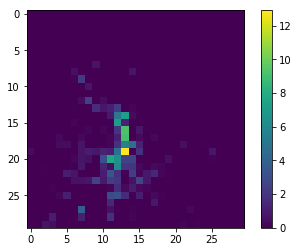

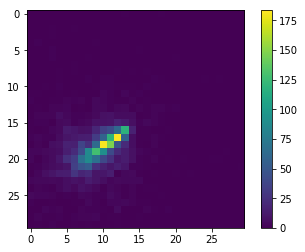

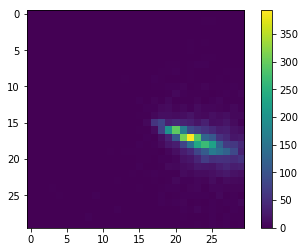

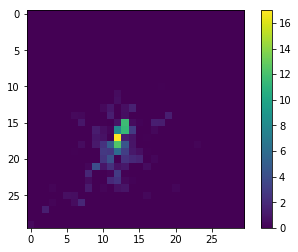

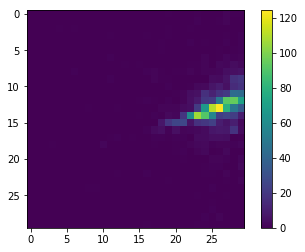

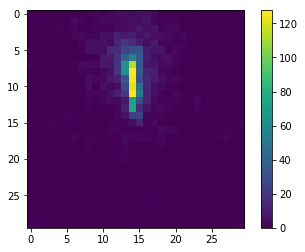

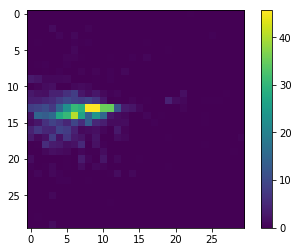

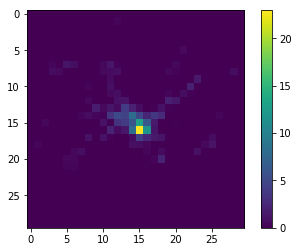

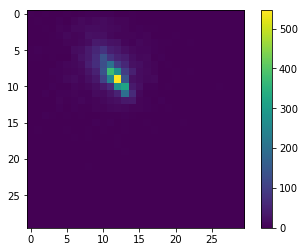

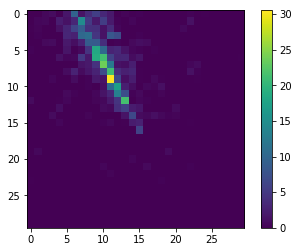

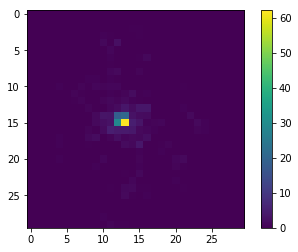

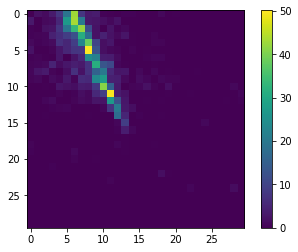

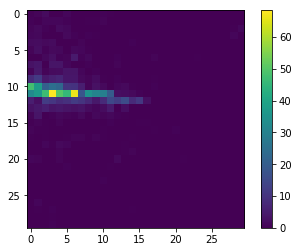

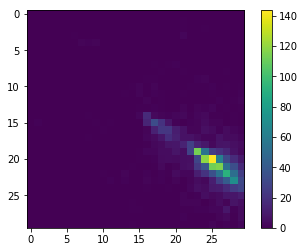

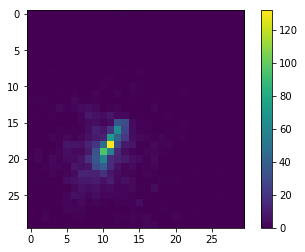

In [6]:
idxs = np.random.choice(np.arange(100), size=15)
print ('REAL')
for ind, elem in enumerate(data_img[idxs]):
    #print (np.log(elem+1))
    plt.imshow(elem)
    plt.colorbar()
    plt.show()

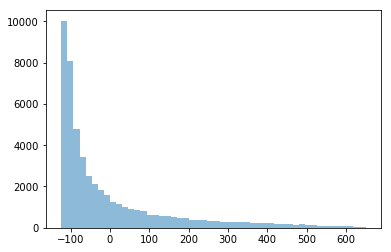

In [7]:
data_img -= data_img.mean()
data_img /= data_img.std()

plt.hist(np.sum(data_img, axis=(1,2)), bins = 50, alpha = 0.5)

plt.show()

REAL


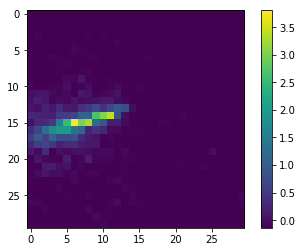

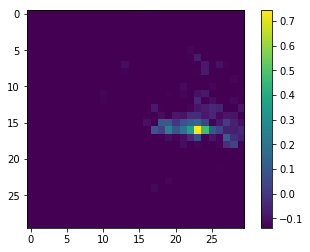

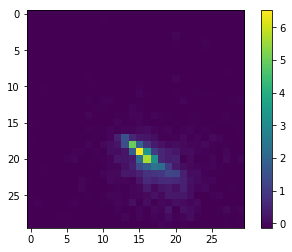

In [8]:
idxs = np.random.choice(np.arange(100), size=3)
print ('REAL')
for ind, elem in enumerate(data_img[idxs]):
    #print (np.log(elem+1))
    plt.imshow(elem)
    plt.colorbar()
    plt.show()

In [9]:
CODE_SIZE = 900

def sample_noise_batch(bsize):
    return np.random.uniform(0, 1,size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data_img.shape[0]), size=bsize)
    answ = data_img[idxs]
    res_answ = [elem.reshape([IMG_SHAPE[0], IMG_SHAPE[1], 1]) for elem in answ] #TODO maybe don't flatten just yet and use conv
    return np.array(res_answ)



In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
from keras.models import Sequential
from keras.layers import *

OUT_SIZE = (IMG_SHAPE[0], IMG_SHAPE[1], 1)

gen = Sequential()
gen.add(InputLayer([CODE_SIZE]))
gen.add(Reshape([30, 30, 1]))
gen.add(Conv2D(filters=8, kernel_size=(4,4), padding='valid',input_shape=(30,30,1),activation='relu'))
print (gen.output_shape[1:])
gen.add(Conv2D(filters=16, kernel_size=(2,2), padding='valid',input_shape=(30,30,1),activation='relu'))
print (gen.output_shape[1:])
gen.add(Flatten())
print (gen.output_shape[1:])
gen.add(Dense(16, activation='relu'))
print (gen.output_shape[1:])
gen.add(Dense(64, activation='relu'))
print (gen.output_shape[1:])

gen.add(Dense(64, activation='elu'))
gen.add(Dense(np.prod(np.array(IMG_SHAPE))))
print (gen.output_shape[1:])
gen.add(Reshape((IMG_SHAPE[0], IMG_SHAPE[1], 1), input_shape=(np.prod(np.array(IMG_SHAPE)),)))


Using TensorFlow backend.


(27, 27, 8)
(26, 26, 16)
(10816,)
(16,)
(64,)
(900,)


In [11]:
from keras.models import Sequential
from keras.layers import *

OUT_SIZE = (IMG_SHAPE[0], IMG_SHAPE[1], 1)

gen = Sequential()
gen.add(InputLayer([CODE_SIZE]))
gen.add(Dense(6 * 6 * 64, activation='relu'))
gen.add(Reshape([6, 6, 64]))
gen.add(Conv2D(32, kernel_size=4, padding='same', activation='relu'))
gen.add(UpSampling2D())
gen.add(Deconv2D(32, kernel_size=4, activation='relu'))
gen.add(UpSampling2D())
gen.add(Conv2D(32, kernel_size=4, padding='same', activation='relu'))
gen.add(Conv2D(1, 1))

Using TensorFlow backend.


In [11]:
assert gen.output_shape[1:] == OUT_SIZE

In [12]:
z = tf.placeholder('float32',[None, CODE_SIZE])

real_data = tf.placeholder('float32',(None,) + OUT_SIZE)

In [13]:
gen_data = gen(z)

quantile_loss = quantile_loss(tf.reduce_sum(gen_data, [1,2,3]),
                              tf.reduce_sum(real_data, [1,2,3])) # for images, sum over all axes except batch



loss = 1e-3 * quantile_loss # add adversarial loss here :)

In [17]:
with tf.variable_scope("adam"):
    step = tf.train.AdamOptimizer(1e-4).minimize(loss)

ValueError: Variable adam/conv2d_1/kernel/Adam/ already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-14-42052dd87234>", line 2, in <module>
    step = tf.train.AdamOptimizer(1e-4).minimize(loss)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/opt/conda/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):


In [18]:
from IPython.display import clear_output
from tqdm import tnrange
import pandas as pd
ewma = lambda x, span=10: pd.ewma(np.asarray(x), span=span)
history = []

sess.run(tf.global_variables_initializer())

In [19]:
# sess.run(tf.variables_initializer(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="adam")))

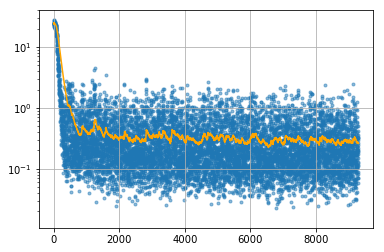

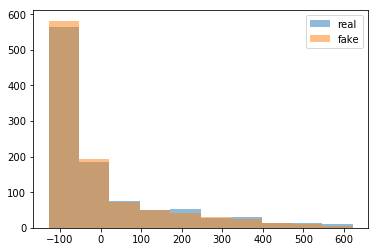

L: 0.226959


In [ ]:


for t in tnrange(10000):
    noise_batch = sample_noise_batch(1024)
    data_batch = sample_data_batch(1024)
    loss_t = sess.run([loss, step], {z: noise_batch,
                            real_data: data_batch})[0]
    
    history.append(loss_t)
    
    if t%100 == 0:
        clear_output(True)
        plt.scatter(range(len(history)), history, marker='.', alpha=0.5)
        plt.plot(ewma(history, 200), c='orange')
        plt.grid()
        plt.yscale('log')
        plt.show()
        
        real_energy_batch = data_batch.sum((1,2,3))
        gen_energy_batch = sess.run(gen_data, {z: noise_batch}).sum((1,2,3))
        hist_range = [min(np.min(real_energy_batch), np.min(gen_energy_batch)),
                      max(np.max(real_energy_batch), np.max(gen_energy_batch))]
        plt.hist(real_energy_batch,alpha=0.5, label='real', range=hist_range);
        plt.hist(gen_energy_batch,alpha=0.5, label='fake', range=hist_range);
        plt.legend(loc='best')
        plt.show()
        
        print('L:', np.mean(history[-100:]))

** energy in loss **

In [ ]:
figsize(8,8)

plt.plot(np.log(loss_history[100:]))
plt.grid()

In [ ]:
generated_preds.shape

In [ ]:
pred_sum_energy = np.sum(generated_preds, axis = 1)

In [ ]:
plt.hist(np.sum(sample_data_batch(5000), axis=1), bins = 50, alpha = 0.5)
plt.hist(pred_sum_energy, bins = 50, alpha = 0.5)
plt.show()

In [ ]:
prediction = [elem.reshape(IMG_SHAPE[0], IMG_SHAPE[1]) for elem in generated_preds]
prediction = np.array(prediction)
prediction.shape

In [ ]:
idxs = np.random.choice(np.arange(100), size=3)
print ('GEN')
for ind, elem in enumerate(prediction[idxs]):
    #print (np.log(elem+1))
    plt.imshow(elem)
    plt.colorbar()
    plt.show()

In [ ]:
p_value_history = []
for i in range(1000):
    random_direction = np.random.normal(size=[5,1])
    targets = get_targets(5000)
    proj_preds = np.dot(generated_preds, random_direction)/np.sqrt(np.sum(random_direction**2))
    proj_targets = np.dot(targets, random_direction)/np.sqrt(np.sum(random_direction**2))
    _, p_value = stats.ks_2samp(proj_targets.flatten(),proj_preds.flatten())
    if p_value < 0.0005:
        plt.hist(proj_preds, bins=100, normed=True, alpha=0.3, color='b')
        plt.hist(proj_targets, bins=100, normed=True, alpha=0.3, color='g')
        plt.grid()
        plt.show()
        break
    p_value_history.append(p_value)
# p_value_history = np.array(p_value_history)
# print np.mean(p_value_history > 0.05)

In [ ]:
plt.hist(p_value_history[p_value_history < 0.0005], bins=30)
plt.grid()